In [1]:
import polars as rs

In [2]:
df = rs.read_csv("../data_punctualite_typedetrain.csv", separator=';')

In [3]:
df

Month,Train type,Punctuality,Number of operated trains,Number of trains with a delay inferior to 6 minutes,Minutes of delay
str,str,f64,i64,i64,i64
"""2016-01""","""P""",84.850414,7855,6665,22695
"""2016-02""","""P""",87.093141,8879,7733,22372
"""2016-02""","""S""",92.473173,19663,18183,33508
"""2016-03""","""IC""",89.789407,50144,45024,112516
"""2016-03""","""P""",87.54201,8629,7554,20811
…,…,…,…,…,…
"""2024-11""","""P""",83.854896,6423,5386,19335
"""2024-12""","""IC""",90.67561,49644,45015,93052
"""2025-03""","""IC""",90.499892,41789,37819,81759


In [4]:
def month_to_season(month: int) -> str:
    if month in [1, 2, 12]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "autumn"

In [5]:
# normalized data per season

df_season = df.with_columns(
    rs.col("Month") \
        .map_elements(lambda e: month_to_season(int(e.split("-")[1])), return_dtype=rs.String) \
        .alias("Season")
)

In [6]:
df_season

Month,Train type,Punctuality,Number of operated trains,Number of trains with a delay inferior to 6 minutes,Minutes of delay,Season
str,str,f64,i64,i64,i64,str
"""2016-01""","""P""",84.850414,7855,6665,22695,"""winter"""
"""2016-02""","""P""",87.093141,8879,7733,22372,"""winter"""
"""2016-02""","""S""",92.473173,19663,18183,33508,"""winter"""
"""2016-03""","""IC""",89.789407,50144,45024,112516,"""spring"""
"""2016-03""","""P""",87.54201,8629,7554,20811,"""spring"""
…,…,…,…,…,…,…
"""2024-11""","""P""",83.854896,6423,5386,19335,"""autumn"""
"""2024-12""","""IC""",90.67561,49644,45015,93052,"""winter"""
"""2025-03""","""IC""",90.499892,41789,37819,81759,"""spring"""


In [7]:
df_sum = df_season.group_by("Season").agg([
    rs.col("Minutes of delay").sum().alias("total_delay"),
    rs.col("Number of operated trains").sum().alias("total_trains")
])

df_avg = df_sum.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)

# df_sum.select(rs.col("Season"), rs.col("total_delay"), rs.col("total_trains"))
df_avg.select(rs.col("Season"), rs.col("Normalized delay"))

Season,Normalized delay
str,f64
"""summer""",1.835144
"""winter""",2.031547
"""autumn""",2.435647
"""spring""",1.963881


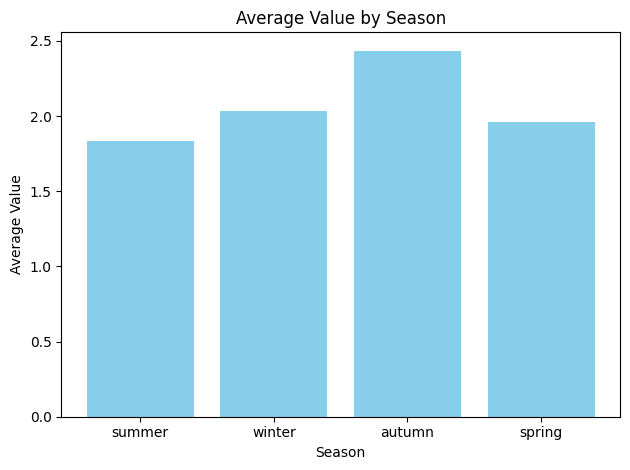

In [8]:
import matplotlib.pyplot as plt

plt.bar(df_avg["Season"], df_avg["Normalized delay"], color="skyblue")
plt.xlabel("Season")
plt.ylabel("Average Value")
plt.title("Average Value by Season")
plt.tight_layout()
plt.show()

In [9]:
df_sum_train_season = df_season.group_by(["Train type", "Season"]).agg([
    rs.col("Minutes of delay").sum().alias("total_delay"),
    rs.col("Number of operated trains").sum().alias("total_trains")
])

df_avg = df_sum_train_season.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)

df_avg.select(rs.col("Season"), rs.col("Train type"), rs.col("Normalized delay"))

Season,Train type,Normalized delay
str,str,f64
"""spring""","""INT""",34.688312
"""winter""","""S""",1.964798
"""spring""","""L""",1.620823
"""summer""","""INT""",18.517073
"""spring""","""ICT""",1.295918
…,…,…
"""spring""","""S""",1.907536
"""summer""","""ICT""",1.781755
"""autumn""","""S""",2.538109


shape: (4, 5)
┌────────────┬────────┬─────────────┬──────────────┬──────────────────┐
│ Train type ┆ Season ┆ total_delay ┆ total_trains ┆ Normalized delay │
│ ---        ┆ ---    ┆ ---         ┆ ---          ┆ ---              │
│ str        ┆ str    ┆ i64         ┆ i64          ┆ f64              │
╞════════════╪════════╪═════════════╪══════════════╪══════════════════╡
│ IC         ┆ winter ┆ 3179388     ┆ 1391084      ┆ 2.285547         │
│ IC         ┆ summer ┆ 2802337     ┆ 1333322      ┆ 2.101771         │
│ IC         ┆ autumn ┆ 3572064     ┆ 1314757      ┆ 2.716901         │
│ IC         ┆ spring ┆ 2996328     ┆ 1335042      ┆ 2.24437          │
└────────────┴────────┴─────────────┴──────────────┴──────────────────┘


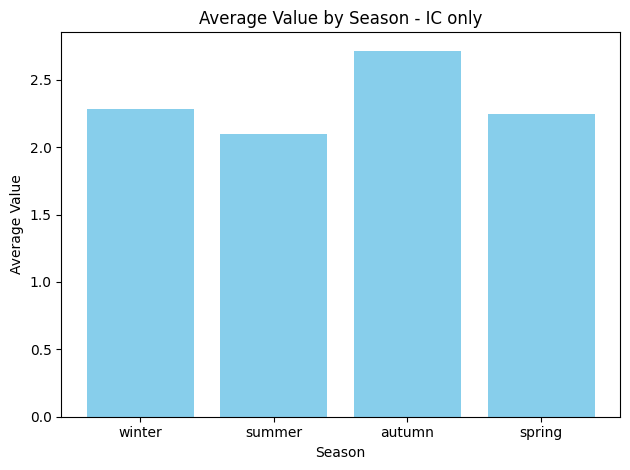

In [10]:
df_ic = df_avg.filter(rs.col("Train type") == "IC")
print(df_ic)

plt.bar(df_ic["Season"], df_ic["Normalized delay"], color="skyblue")
plt.xlabel("Season")
plt.ylabel("Average Value")
plt.title("Average Value by Season - IC only")
plt.tight_layout()
plt.show()

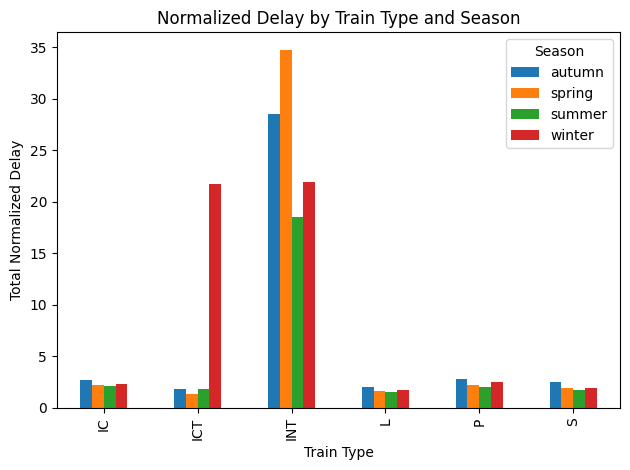

In [11]:
df_avg_pd = df_avg.to_pandas()
df_avg_pd = df_avg_pd.pivot(index='Train type', columns='Season', values='Normalized delay')
df_avg_pd.plot(kind="bar", stacked=False)


plt.xlabel("Train Type")
plt.ylabel("Total Normalized Delay")
plt.title("Normalized Delay by Train Type and Season")
plt.tight_layout()
plt.show()

# Pas op voor onderstaande grafiek:
sommige types trainen hebben geen datapunten over heel de dataset. Oplossen door enkel het jaar te tonen waar alle types datapunten hebben --> mogelijks nutteloze grafiek aangezien dit voor 1 specifiek jaar is?

In [12]:
# % treinen vertraging vergelijken met hoeveel treinen er rijden

df_corr = df_season.filter(rs.col("Train type").is_in(["IC", "L", "P"])).group_by("Train type").agg([
        rs.col("Number of operated trains").sum().alias("Total operated trains"),
        rs.col("Number of trains with a delay inferior to 6 minutes").sum().alias("Total delayed trains")
]).with_columns((rs.col("Total delayed trains") / rs.col("Total operated trains")).alias("Correlation"))

df_corr

Train type,Total operated trains,Total delayed trains,Correlation
str,i64,i64,f64
"""L""",5067412,4647727,0.91718
"""P""",827209,723420,0.874531
"""IC""",5374205,4743625,0.882665


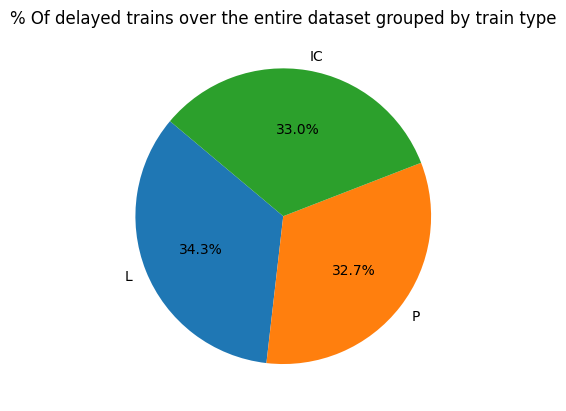

In [13]:
total_sum = df_corr.select("Correlation").sum()[0, 0]

plt.pie(df_corr["Correlation"] / total_sum, labels=df_corr["Train type"], autopct='%1.1f%%', startangle=140)
plt.title("% Of delayed trains over the entire dataset grouped by train type")
plt.show()

Note: hier is de hele dataset gebruikt, maar de 3 "speciale" treinen zijn niet in rekening gebracht. Dit omdat deze amper data in de set bevatten.

In [14]:
# min-max in connected dot plot

df_1_year = df.filter(rs.col("Month").str.contains("2020"))
df_min_max = df_1_year.group_by("Train type").agg([
    rs.col("Minutes of delay").min().alias("Min delay"),
    rs.col("Minutes of delay").max().alias("Max delay")
])

df_melted = df_min_max.to_pandas().melt(id_vars="Train type", value_vars=["Min delay", "Max delay"], 
                                   var_name="Delay Type", value_name="Delay Value")
df_melted

,Train type,Delay Type,Delay Value
0,P,Min delay,1185
1,ICT,Min delay,0
2,L,Min delay,22640
3,IC,Min delay,22904
4,P,Max delay,20799
5,ICT,Max delay,2317
6,L,Max delay,86665
7,IC,Max delay,110430


Text(0, 0.5, 'Train Type')

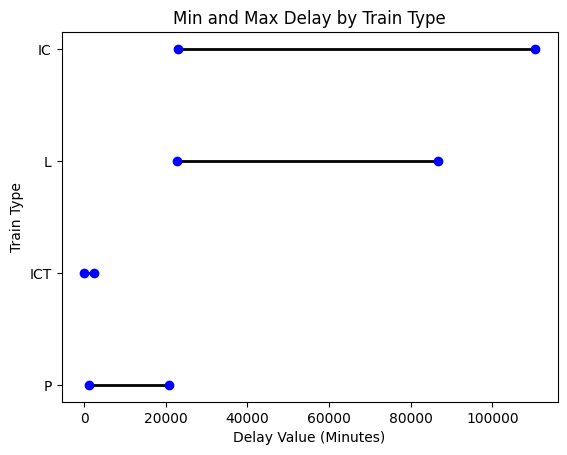

In [15]:
import seaborn as sns

# Plot the dots and lines for each category
for row in df_min_max.iter_rows(named=True):
    # Get the min and max delays for each category
    min_delay = row["Min delay"]
    max_delay = row["Max delay"]
    train_type = row["Train type"]
    
    # Plot the dots for min and max
    plt.scatter([min_delay, max_delay], [train_type, train_type], color='blue', zorder=5)
    
    # Connect the dots with a line
    plt.plot([min_delay, max_delay], [train_type, train_type], color='black', lw=2)

# Customize the plot
plt.title("Min and Max Delay by Train Type")
plt.xlabel("Delay Value (Minutes)")
plt.ylabel("Train Type")

# Grid of bar chart
Cluster bar chart on season, split up on train type

In [16]:
def month_to_season(month: int) -> str:
    if month in [1, 2, 12]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "autumn"

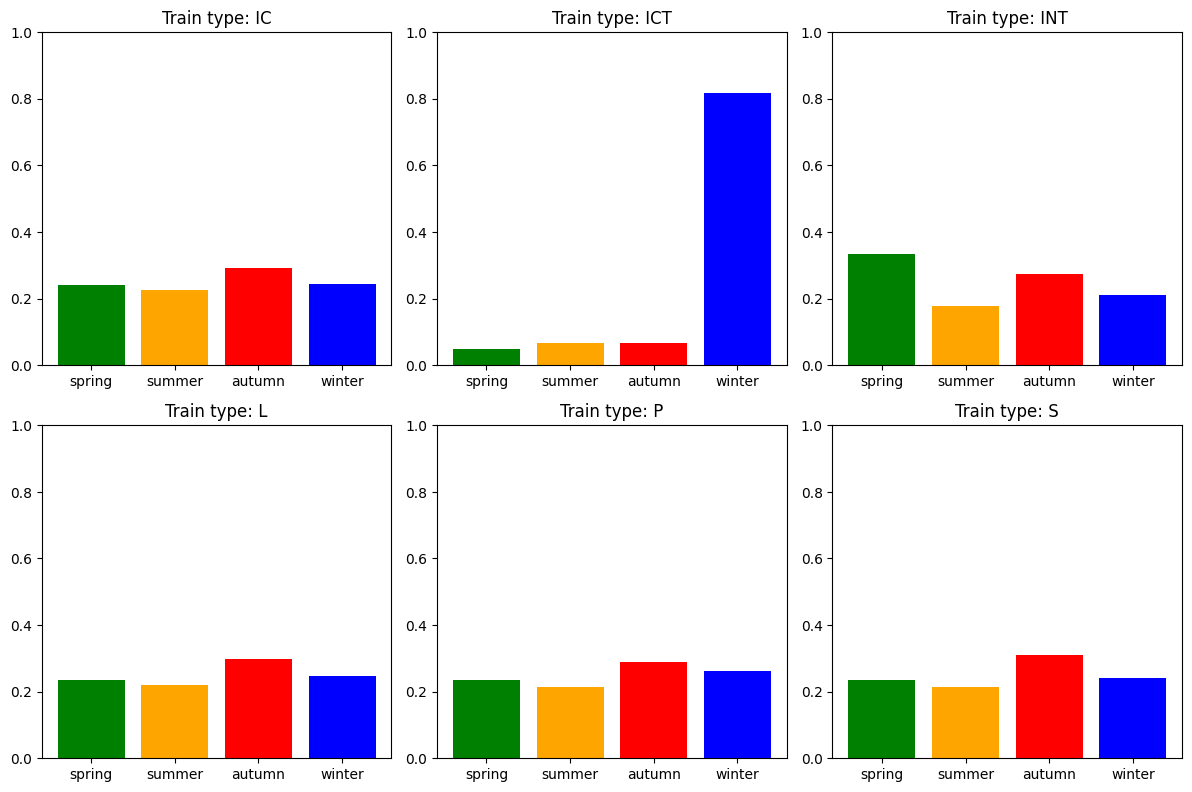

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
train_types = ["IC", "ICT", "INT", "L", "P", "S"]

season_order = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}
total_sum_season = df_avg.select("Normalized delay").sum()[0, 0]

df_season = df.with_columns(
    rs.col("Month") \
        .map_elements(lambda e: month_to_season(int(e.split("-")[1])), return_dtype=rs.String) \
        .alias("Season")
)

df_sum_train_season = df_season.group_by(["Train type", "Season"]).agg([
    rs.col("Minutes of delay").sum().alias("total_delay"),
    rs.col("Number of operated trains").sum().alias("total_trains")
])

df_avg = df_sum_train_season.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)
df_normalized = df_avg.sort(rs.col("Season").replace_strict(season_order)) \
    .with_columns((rs.col("Normalized delay") / total_sum_season).alias("Normalized^2 delay"))

colors = {
    "spring": "green",
    "summer": "orange",
    "autumn": "red",
    "winter": "blue"
}

for i in range(len(ax)):
    frame = df_normalized.filter(rs.col("Train type") == train_types[i])
    summed = frame.select("Normalized delay").sum()[0, 0]

    normalized_frame = frame.with_columns((rs.col("Normalized delay") / summed).alias("Normalized^2 delay"))

    ax[i].bar(normalized_frame["Season"], normalized_frame["Normalized^2 delay"], color=[colors[s] for s in normalized_frame["Season"]])
    ax[i].set_title("Train type: " + train_types[i])
    ax[i].set_ylim(0, 1)

plt.tight_layout(pad=1.0)
plt.show()

# Stacked bar chart

In [18]:
train_types = ["IC", "L", "P"]
season_order = {'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3}

df_season = df.with_columns(
    rs.col("Month") \
        .map_elements(lambda e: month_to_season(int(e.split("-")[1])), return_dtype=rs.String) \
        .alias("Season")
)

df_sum_train_season = df_season \
    .filter(rs.col("Train type") \
    .is_in(train_types)).group_by(["Train type", "Season"]) \
    .agg([
        rs.col("Minutes of delay").sum().alias("total_delay"),
        rs.col("Number of operated trains").sum().alias("total_trains")
    ])

df_avg = df_sum_train_season.with_columns(
    (rs.col("total_delay") / rs.col("total_trains")).alias("Normalized delay")
)

df_train_type_sum = df_avg.group_by("Train type").agg(
    rs.col("Normalized delay").sum().alias("Total sum per train type")
)

joined = df_avg.join(df_train_type_sum, on="Train type", how="inner")

df_normalized = joined \
    .with_columns((rs.col("Normalized delay") / rs.col("Total sum per train type")) \
         .alias("Normalized delay train type")
    )  \
    .sort(rs.col("Season").replace_strict(season_order))
df_normalized

Train type,Season,total_delay,total_trains,Normalized delay,Total sum per train type,Normalized delay train type
str,str,i64,i64,f64,f64,f64
"""L""","""spring""",2022389,1247754,1.620823,6.893531,0.235122
"""P""","""spring""",470172,209209,2.247379,9.604713,0.233987
"""IC""","""spring""",2996328,1335042,2.24437,9.348588,0.240076
"""P""","""summer""",329261,159265,2.067378,9.604713,0.215246
"""L""","""summer""",1881960,1233459,1.525758,6.893531,0.221332
…,…,…,…,…,…,…
"""IC""","""autumn""",3572064,1314757,2.716901,9.348588,0.290621
"""P""","""autumn""",645621,231840,2.78477,9.604713,0.289938
"""P""","""winter""",568414,226895,2.505185,9.604713,0.260829


In [19]:
df_normalized.plot.bar(x="Train type", y="Normalized delay train type", color="Season") \
    .properties(width=400, height=300)

alt.Chart(...)